# DSS Example: Avoided Harvesting

This notebook is an example implementation of a notebook-based decision-support system (DSS) for evaluating the net system-level carbon emissions impact of an _avoided harvesting_ type project. 

## DSS implementation notes

At its core this DSS prototype uses ws3 and libcbm_py to do most of the heavy lifting in terms of simulating forest growth, simulating harvesting disturbances, and simulating forest ecosystem carbon stocks and fluxes. ws3 includes built-in functions that automate most of process of compiling CBM input data, importing this input data into CBM, running CBM, and extracting CBM output data in tablular format. We layer onto this some custom functions to simulate multiple decaying pools of harvested wood products (HWP), and displacement effects for these. 

This DSS assumes we are using the standard "alternative scenario net of baseline scenario" approach to defining net carbon emissions, so we include functions that automate the process of pushing a pair of (baseline, alternative) scenarios through the simulation pipeline, collecting the output from each scenario, calculating the difference across scenarios (alternative minus baseline) and displaying this contrast as a function of time.

We include a few interactive widgets to show how these can be used to implement a more user-friendly interface for the DSS while keeping the flexibility and low overhead cost of using a Jupyter notebook environment to implement the DSS. 

Note that most of the complex code that defines the behaviour of the DSS and underlying simulation engines is implemented in a companion `util` Python module. The functions we need from the `util` module are imported at the top of this notebook. 

It is also possible to further "hide" the code parts of a Jupyter notebook-based DSS dashboard application by linking _all_ required parameters and controls to interactive widgets (see some examples of widgets below), and then running the notebook throught the Voilà dashboard interface (not tested here, but Voilà is part of the standard ecosystem of Jupyter software should not be a problem). For anyone more familiar with the R programming environment, Voilà is to JupyterLab as Shiny is to RStudio (if this analogy is lost on you, then it was not meant for you). 

## Description of case

The study area for this case is a part of timber supply area (TSA) 04 in British Columbia around a mining site. There has been little or no harvesting in this area to date, but in this hypothetical case we are supposing that there are plans to begin actively harvesting this area in the near future. We are assuming that harvesting will be planned such that an _even flow_ of merchantable timber volume is extracted from the study area (over an arbitrary 100-year simulation horizon, althought the system can easily be parametrized to simulate shorter or longer horizons). We assume that the harvesting will begin unless someone "buys out" and holds the harvesting rights without exploiting them (effectively implementing a "no harvesting" policy going forward). In this situation, the "harvesting" policy represents the baseline scenario and the "no harvesting" policy is the alternative scenario.  

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
from util_opt import results_scenarios, run_scenario
import time
import gurobipy as grb

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'

Create some interactive widgets to control four model parameters. The widgets have reasonable default values defined, but DSS users can override these default values. There are many (thousands!) of other model parameters that could modified to tweak model behaviour. These are complex models, and in the end the quality of output data is limited by the quality of input parameter choices (many of which require expert judgement).  

In [4]:
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=0)
hwp_pool = widgets.FloatSlider(min=0, max=1, step=1, description='HWP', value=0)
display(displacement_effect, hwp_pool)

FloatSlider(value=0.0, description='Displacement', max=1.0, step=1.0)

FloatSlider(value=0.0, description='HWP', max=1.0, step=1.0)

In [5]:
displacement_effect = displacement_effect.value
hwp_pool = hwp_pool.value

In [6]:
if displacement_effect == 0:
   clt_percentage = 0
   credibility = 0
else:
    clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5)
    credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1)
    display(clt_percentage, credibility)

FloatSlider(value=0.5, description='CLT_percent:', max=1.0)

FloatSlider(value=1.0, description='Credibility:', max=1.0)

In [7]:
max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=0)
budget_input = widgets.FloatText(
    value=10000000,
    description='Budget:',
    disabled=False)
display(max_harvest, budget_input)

FloatSlider(value=0.0, description='Max_harvest:', max=1.0, step=0.05)

FloatText(value=10000000.0, description='Budget:')

In [8]:
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")
scenario_dropdown = widgets.Dropdown(
    options=['base', 'base-cgen_ha', 'base-cgen_hv', 'base-cgen_gs'],
    value='base',
    description='Scenario:'
)
display(scenario_dropdown)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')

Dropdown(description='Scenario:', options=('base', 'base-cgen_ha', 'base-cgen_hv', 'base-cgen_gs'), value='bas…

In [9]:
if displacement_effect != 0:
    clt_percentage = clt_percentage.value
    credibility = credibility.value
max_harvest = max_harvest.value
budget_input = budget_input.value
scenario_name = scenario_dropdown.value

In [10]:
fm = ws3.forest.ForestModel(model_name='tsa04',
                            model_path='./data/woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

Run the simulations and compile output data into a "dashboard" of graphs. The grid of four subfigures shows carbon stocks and emissions for both baseline and alternative scenarios. The figure on the bottom shows the contrast (difference) between net emissions for alternative and baseline scenarios. The contrast is a negative number (in most time steps), which means that according to this simulation the alternative (no harvesting) scenario generally has lower emissions behaviour than the baseline (high even-flow harvesting) scenario. 

However, close inspection of the detailed scenario-wise emissions graphs reveals that the absolute magnitude of the "net emission" indictator for each of the scenarios is relatively small compared to the absolute magnitude of "ecosystem decay" and "gross growth" emissions (which dominate the net emissions calculation, and come close to cancelling each other out completely). Furthermore, side-by-side visual inspection of the relatively small-magnitude "net emissions" profiles for each scenario shows that they are _very_ similar.

So, althrough this model is calculating a net negative impact of the "no harvesting" scenario relative to the "with harvesting" scenario, the magnitude of this impact is small enough (compared to the magnitude of the constituent carbon emission components that are summed to calculate the net emission indicator) to trigger a "materiality" criterion challenge. Materiality is further challenged when one considers the relatively low confidence (i.e., high uncertainty) associated with some of the key input assumptions used in this deterministic analysis). 

As a further example of how the flexibility of this type of notebook-based DSS implementation, we automate the process of calculating the avoided emissions for the first 25 years of the simulation horizon (i.e., the area under the leftmost part of the curve in the bottom figure in the dashboard), and dividing this number into a hypothetical "budget" for buying out the harvesting rights, yielding a "unit cost of avoided emissions" (in $ per tCO2e). This is the same sort of calculation (minus a full-blown techno-economic analysis to back up the budget value in the numerator) used by economists to compile marginal abatement cost curve (MACC) figures. For example, the DSS prototype as it is implemented could be re-run multiple times to find (through trial and error) the maximum total price one would want to bid to buy out the harvesting rights on this piece of land, given a maximum "unit cost of avoided emissions" price we were willing to pay (above which price maybe it would be more economically efficient to invest our "carbon money" elsewhere, or just purchase ready-baked carbon offset credits from one of several retail voluntary carbon offset markets).

In [11]:
fm.reset()

In [12]:
schedule = run_scenario(fm, scenario_name)
schedule

running base scenario plus harvest volume constraints
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3947 rows, 36130 columns and 442656 nonzeros
Model fingerprint: 0xaaa4f316
Coefficient statistics:
  Matrix range     [1e-02, 9e+04]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 2036 rows and 3905 columns
Presolve time: 0.14s
Presolved: 1911 rows, 32226 columns, 407292 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.685e+04
 Factor NZ  : 9.050e+04 (roughly 14 MB of memory)
 Factor Ops : 4.448e+06 (less than 1 second 

[(('tsa04', '1', '13', '204', '6', '6'),
  87,
  16.903313049357678,
  'harvest',
  1,
  '_existing'),
 (('tsa04', '1', '6', '100', '7', '7'),
  71,
  10.130632436971082,
  'harvest',
  2,
  '_existing'),
 (('tsa04', '1', '13', '204', '6', '6'),
  79,
  3.875752676674104,
  'harvest',
  2,
  '_existing'),
 (('tsa04', '1', '31', '403', '15', '15'),
  122,
  3.7420935881803756,
  'harvest',
  2,
  '_existing'),
 (('tsa04', '1', '6', '100', '7', '7'),
  81,
  6.346715654381467,
  'harvest',
  3,
  '_existing'),
 (('tsa04', '1', '19', '304', '2', '2'),
  97,
  9.413569904757317,
  'harvest',
  3,
  '_existing'),
 (('tsa04', '1', '31', '403', '15', '15'),
  132,
  1.9881931426867774,
  'harvest',
  3,
  '_existing'),
 (('tsa04', '1', '6', '100', '7', '7'),
  91,
  3.4031035023987464,
  'harvest',
  4,
  '_existing'),
 (('tsa04', '1', '13', '204', '4', '4'),
  87,
  12.606944312122412,
  'harvest',
  4,
  '_existing'),
 (('tsa04', '1', '26', '403', '15', '15'),
  102,
  1.7384308873044052,
 

running base scenario plus harvest volume constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3947 rows, 36130 columns and 442656 nonzeros
Model fingerprint: 0xaaa4f316
Coefficient statistics:
  Matrix range     [1e-02, 9e+04]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 2036 rows and 3905 columns
Presolve time: 0.16s
Presolved: 1911 rows, 32226 columns, 407292 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.685e+04
 Factor NZ  : 9.050e+04 (roughly 14 MB of memory)
 Factor Ops : 4.448e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.26 seconds (0.14 work 

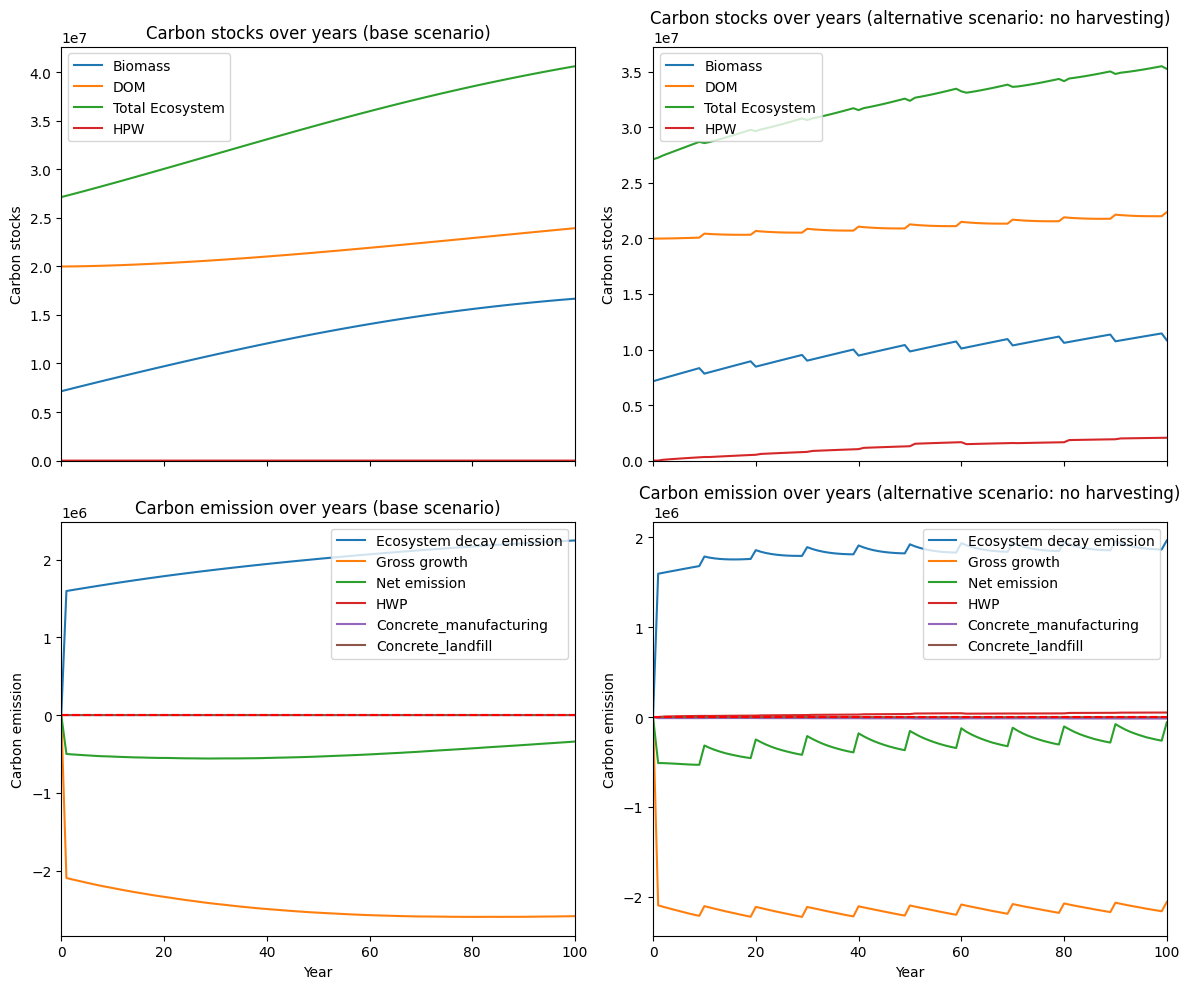

Net emission difference 2668386.036646848
Net emission base scenario -12869717.214708997
Net emission alternative scenario -10201331.178062148
dollar_per_ton is:  3.7475836939119263
It took 7.4 minutes to run this script.


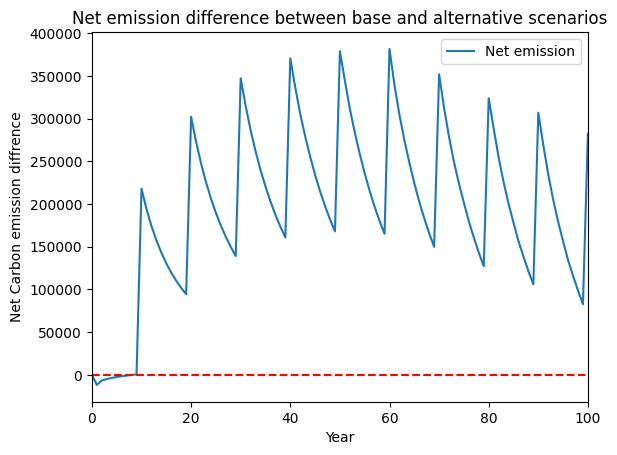

In [13]:
Start = time.time()
results_scenarios(fm, clt_percentage, credibility, budget_input, n_steps, max_harvest, scenario_name)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")